In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/sumie"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/sumie


In [0]:
import sumie.inputs
import sumie.sumie
import sumie.transforms
import sumie.objectives
import sumie.montage

In [4]:
import sumie.utils
model = torchvision.models.vgg16(pretrained=True).eval()
model.features[-1] = torch.nn.AdaptiveMaxPool2d((7, 7))
sumie.utils.remove_inplace(model)
sumie.utils.max_to_avg_pool(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

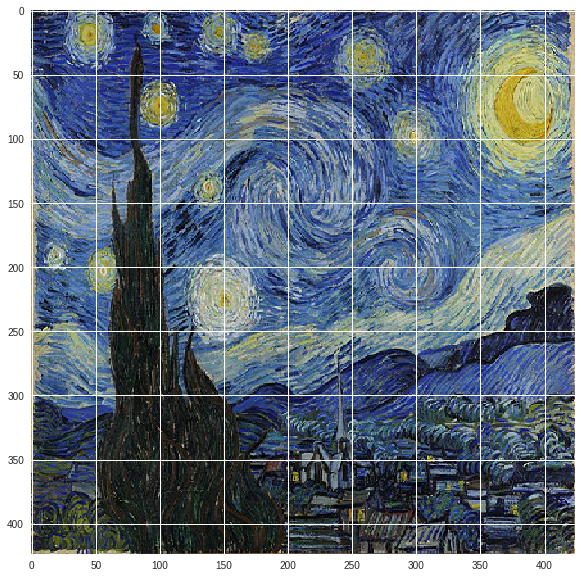

In [9]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/606px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
contents = BytesIO(response.content)
import sumie.montage
im_target_style = sumie.montage.load_image(contents, (424, 424))
im_target_style = im_target_style/255
fig = plt.figure(figsize=(10,10))
sumie.montage.show(255*im_target_style)

In [6]:
[model.features[0], model.features[21]]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [0]:
im = sumie.sumie.Image(224, param='rgb', decorrelate=False, 
                       transforms=[
               #sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise(),]
            )

device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.05)
steps = 1000
history = np.zeros((steps, 1))
style = sumie.objectives.Style([model.features[0], model.features[5], model.features[10], model.features[17], model.features[24]], 
                                 model, 
                                 sumie.transforms.Normalise()(im_target_style).to(device))
for i in range(steps):
    optimiser.zero_grad()
    out = model(im())
    
    loss = style.objective
    history[i] = loss.cpu().detach().numpy()
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    #animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()
    

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9134e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8107e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8675e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3541e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0217e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.9479e-06, device='cuda:0', grad_fn=<AddBackward0>)


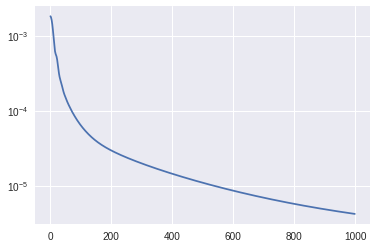

In [11]:

plt.plot(history)
plt.yscale('log')

In [0]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

In [0]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Macaca_sinica_-_01.jpg/320px-Macaca_sinica_-_01.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
contents = BytesIO(response.content)
import sumie.montage
im_target = sumie.montage.load_image(contents, (224, 224))
im_target = im_target/255
sumie.montage.show(255*im_target)

In [0]:
im = sumie.sumie.Image(224, param='fft', decorrelate=True, 
                       transforms=[
               #sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise(),]
            )

device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.05)
steps = 1000
history = np.zeros((steps, 1))
content = sumie.objectives.Content(model.features[19], 
                                 model, 
                                 sumie.transforms.Normalise()(im_target).to(device))
style = sumie.objectives.Style([model.features[0], model.features[5], model.features[10], model.features[17], model.features[24]], 
                                 model, 
                                 sumie.transforms.Normalise()(im_target_style).to(device))
for i in range(steps):
    optimiser.zero_grad()
    out = model(im())
    
    loss = style.objective*500 + content.objective
    history[i] = loss.cpu().detach().numpy()
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    #animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()
    

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

In [0]:
plt.plot(history)
plt.yscale('log')